In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import os
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
bcw_train = pd.read_csv(os.path.join('/content/drive/MyDrive/Datasets/SI_final_project', 'bcw_train.csv'))
bcw_test = pd.read_csv(os.path.join('/content/drive/MyDrive/Datasets/SI_final_project', 'bcw_test.csv'))
model_metrics = pd.read_csv(os.path.join('/content/drive/MyDrive/Datasets/SI_final_project', 'model_metrics.csv'))

MessageError: ignored

In [ ]:
def decision_boudary(model, min_vals, max_vals, num_features, feature_ids=[0,1]):
    """ Calcula las clasificaciones para una malla regular en dos de las dimensiones de
    entrada del modelo.

    - Argumentos:
      model :  modelo de ML previamente entrenado.
      min_vals : array o lista 2D con los valores mínimos de la malla regular.
      max_vals : array o lista 2D con los valores máximos de la malla regular.
      num_features : número de variables de entrada totales del modelo (aunque representemos solo 2
              el modelo puede tener muchas más).
      feature_ids : índices de las variables que vamos usar en la malla regular.
    """
    # Primero generamos una malla de puntos que cubra el espacio de búsqueda en el
    # cuadrado  definido por min_vals y max_vals.
    ranges = [np.arange(min_v-.1, max_v+.1, 0.05) for min_v, max_v in zip(min_vals, max_vals)]
    xx, yy = np.meshgrid(*ranges)

    # Solo nos interesan las 2 primeras variables, rellenamos con ceros el resto.
    X = np.zeros([xx.ravel().shape[0], num_features])
    X[:, feature_ids[0]] = xx.ravel()
    X[:, feature_ids[1]] = yy.ravel()

    # Evaluamos cada punto de la malla en el modelo árbol de decisión. De esta
    # manera, tenemos una aproximación razonable de la decisión que tomaría nuestro
    # modelo en cada punto del espacio de búsqueda.
    zz = model.predict(X).reshape(xx.shape)
    return xx, yy, zz

Para el mario de mañana:
- Iteramos sobre valores de C
- Dentro, iteramos sobre los 4 kernels
- Para cada kernel, hacemos scv 10 fold y pillamos la media para que represente al kernel

In [3]:
# Import CV related libraries
from sklearn.model_selection import StratifiedKFold
# Import performance related libraries
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, confusion_matrix, RocCurveDisplay)
# Import ML model
from sklearn.svm import SVC

scv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
X, y = bcw_train.drop('target', axis=1), bcw_train['target']

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
C_values = [1e-3, 1e-2, 0.1, 1, 10, 100]

# Initialize an empty DataFrame to hold the results
all_results = pd.DataFrame([], columns=['Performance', 'Kernel', 'C', 'PType'])

for c_val in C_values:
    for ker in kernels:
        fold_metrics = {'F1-Score': [], 'Accuracy': []}

        for i, (train, validation) in enumerate(scv.split(X, y)):
            svc_aux = SVC(C=c_val, kernel=ker)
            svc_aux.fit(X.iloc[train], y.iloc[train])

            y_pred = svc_aux.predict(X.iloc[validation])
            fold_metrics['F1-Score'].append(f1_score(y.iloc[validation], y_pred))
            fold_metrics['Accuracy'].append(accuracy_score(y.iloc[validation], y_pred))

        # Populate the DataFrame for this iteration
        aux_df = pd.DataFrame({
            'Performance': [np.mean(fold_metrics['Accuracy'])],
            'Kernel': [ker],
            'C': [c_val],
            'PType': ['Accuracy']
        })
        # Append Accuracy DataFrame to the overall results
        all_results = pd.concat([all_results, aux_df], ignore_index=True)
        aux_df = pd.DataFrame({
            'Performance': [np.mean(fold_metrics['F1-Score'])],
            'Kernel': [ker],
            'C': [c_val],
            'PType': ['F1-Score']
        })
        # Append F1-Score DataFrame to the overall results
        all_results = pd.concat([all_results, aux_df], ignore_index=True)

    # Plotting for each C value
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Kernel", y="Performance", hue="PType",
                  data=all_results[all_results['C'] == c_val],
                  palette="Set2")

    plt.title(f'C={c_val}')
    plt.ylim(0, 1)
    plt.show()



NameError: ignored

In [ ]:
idx = all_results[all_results['PType'] == 'Accuracy'].groupby('Kernel')['Performance'].idxmax()
print(all_results.loc[idx, ['Kernel', 'C', 'Performance', 'PType']].to_latex(index=True,
                  float_format="{:.3f}".format,
))

\begin{tabular}{llrrl}
\toprule
{} &   Kernel &       C &  Performance &     PType \\
\midrule
24 &   linear &   1.000 &        0.974 &  Accuracy \\
44 &     poly & 100.000 &        0.947 &  Accuracy \\
34 &      rbf &  10.000 &        0.966 &  Accuracy \\
22 &  sigmoid &   0.100 &        0.942 &  Accuracy \\
\bottomrule
\end{tabular}



In [1]:
idx = all_results[all_results['PType'] == 'F1-Score'].groupby('Kernel')['Performance'].idxmax()
print(all_results.loc[idx, ['Kernel', 'C', 'Performance', 'PType']].to_latex(index=True,
                  float_format="{:.3f}".format,
))

NameError: ignored

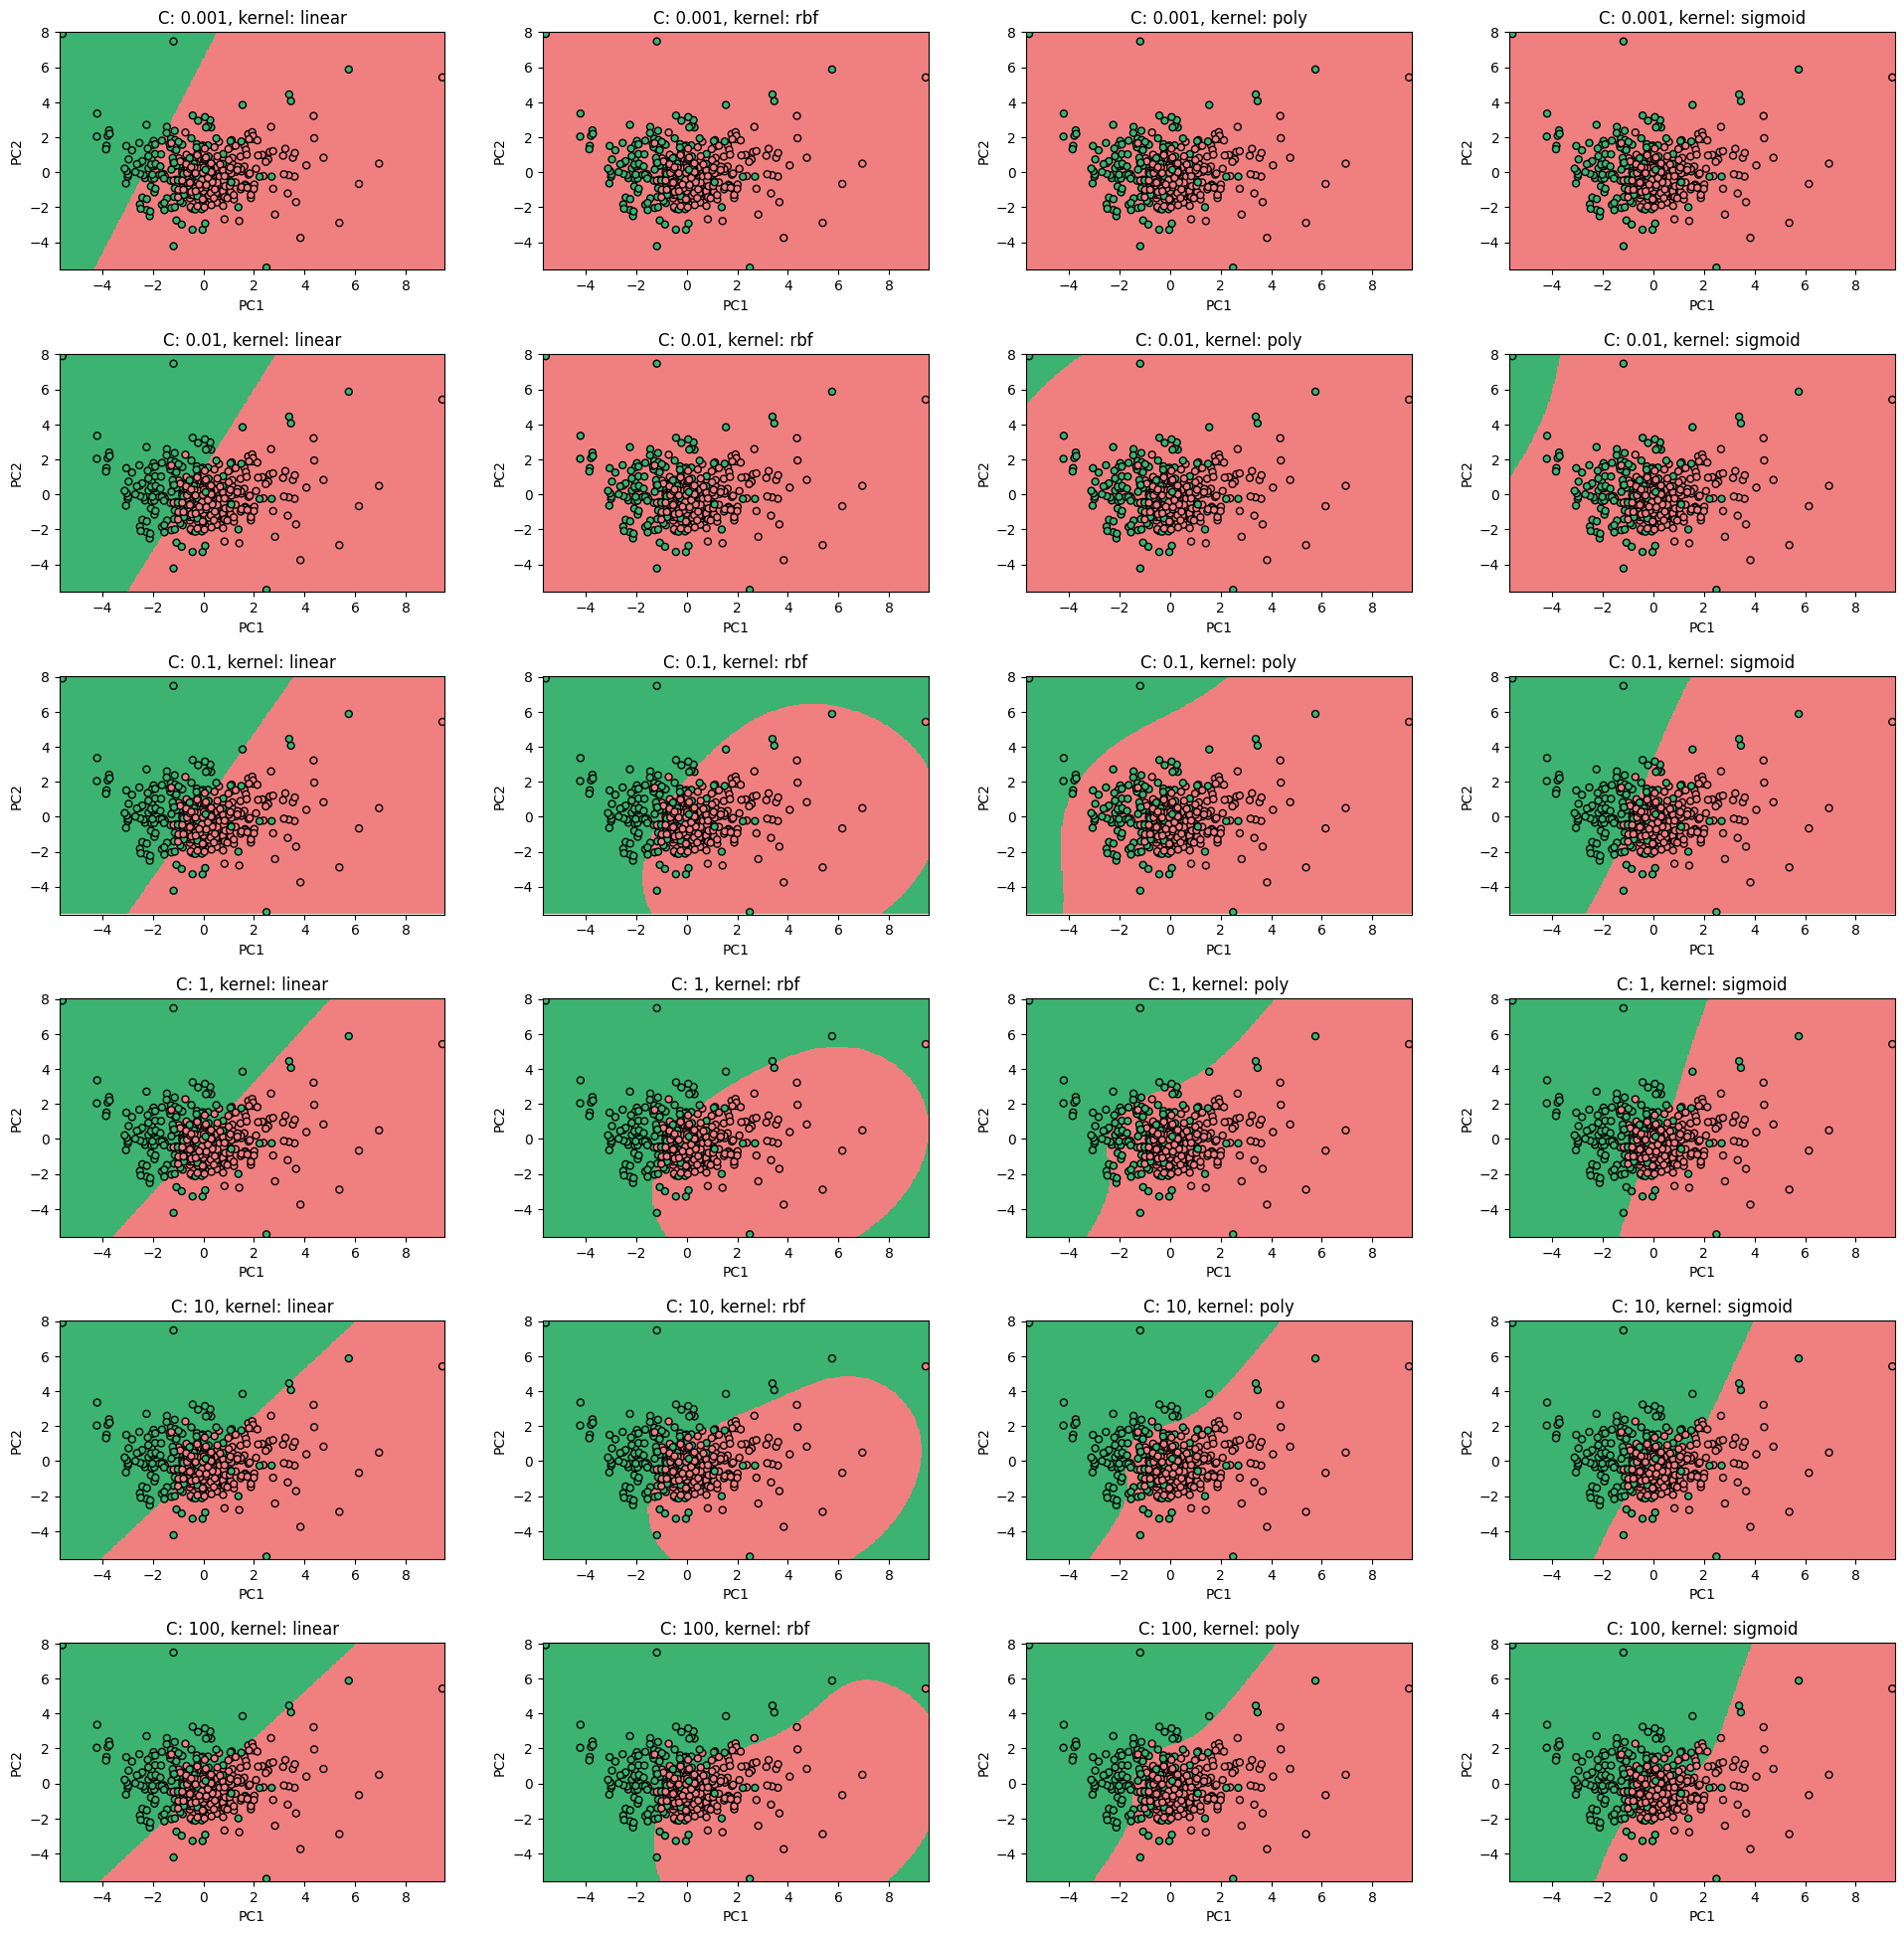

In [ ]:
from matplotlib import pyplot as plt

scv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
X_train, y_train = bcw_train.drop('target', axis=1), bcw_train['target']
pcs = [1, 2]
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
C_values = [1e-3, 1e-2, 0.1, 1, 10, 100]

# Initialize an empty DataFrame to hold the results
all_results = pd.DataFrame([], columns=['Performance', 'Kernel', 'C', 'PType'])

# Create a 6x4 grid of subplots
fig, axes = plt.subplots(6, 4, figsize=(20, 20))
fig.tight_layout(pad=4.0)  # Padding

plot_idx = 0

for c_val in C_values:
    for ker in kernels:
        fold_metrics = {'F1-Score': [], 'Accuracy': []}

        for i, (train, validation) in enumerate(scv.split(X_train, y_train)):
            svc = SVC(C=c_val, kernel=ker)
            svc.fit(X_train.iloc[train], y_train.iloc[train])

            y_pred = svc.predict(X_train.iloc[validation])
            fold_metrics['F1-Score'].append(f1_score(y_train.iloc[validation], y_pred))
            fold_metrics['Accuracy'].append(accuracy_score(y_train.iloc[validation], y_pred))

        # Plotting decision boundary
        ax = axes.flat[plot_idx]  # Get the current axis
        # Calculamos la frontera de decisión.
        xx, yy, zz = decision_boudary(svc, X_train.min(0)[pcs], X_train.max(0)[pcs], \
                                      X_train.shape[1], feature_ids=pcs)
        # Pintamos la frontera de decisión
        cmap = colors.ListedColormap(['lightcoral', 'mediumseagreen'])
        ax.pcolormesh(xx, yy, zz.astype(float), cmap=cmap)
        clrs = [ ('lightcoral', 'mediumseagreen')[int(y_i)] for y_i in y_train]
        ax.scatter(X_train.values[:, pcs[0]], X_train.values[:, pcs[1]], ec='k', color=clrs, s=25)
        ax.set_title(f'C: {c_val}, kernel: {ker}')
        ax.set_xlabel(f'PC{pcs[0]}')
        ax.set_ylabel(f'PC{pcs[1]}')
        plot_idx += 1
plt.show()


## Alternative fine tuning I found interesting: C vs Gamma vs Performance for each kernel

In [ ]:
# Import necessary libraries for 3D plotting
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_for_kernel_with_color(kernel, C_values, gamma_values, performance):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Get a color map
    color_map = plt.cm.get_cmap('viridis', len(C_values))

    for idx, C in enumerate(C_values):
        for gamma in gamma_values:
            # Replace 'performance' with the actual performance metric (e.g., F1-Score or Accuracy)
            perf = np.random.choice(performance)  # Dummy performance value, replace with real one
            sc = ax.scatter(C, gamma, perf, c=[color_map(idx / len(C_values))], marker='o')

    # Labels and title
    ax.set_xlabel('C Value')
    ax.set_ylabel('Gamma Value')
    ax.set_zlabel('Performance')
    ax.set_title(f'3D Representation of C, Gamma for Kernel: {kernel}')
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=min(C_values), vmax=max(C_values)))
    sm.set_array([])
    plt.colorbar(sm, label='C Value', ticks=np.linspace(min(C_values), max(C_values), len(C_values)), orientation='vertical')
    plt.show()

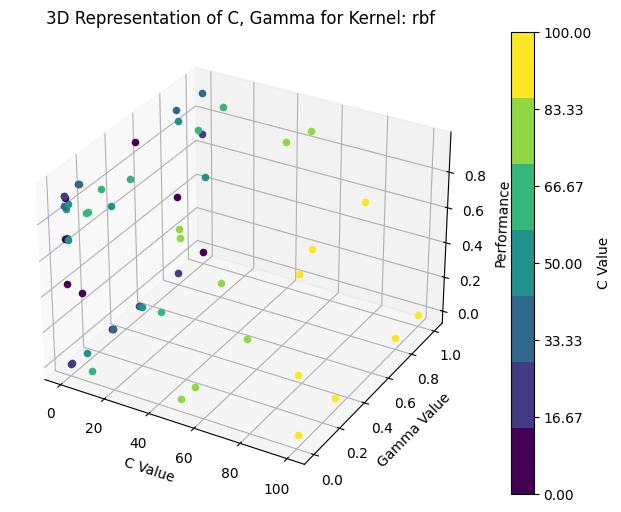

In [ ]:
scv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
X, y = bcw_train.drop('target', axis=1), bcw_train['target']
performances = []
C_values = [1e-3, 1e-2, 0.1, 1, 10, 50, 100]
gamma_values = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.8, 1]
kernels = ['rbf']  # We could do this for every non-linear kernel, but lets pick rbf

# Loop over hyperparameters
for C in C_values:
    for gamma in gamma_values:
        for kernel in kernels:
            fold_metrics = {'F1-Score': [], 'Accuracy': []}

            # Stratified K-Fold Cross Validation
            for train_idx, test_idx in scv.split(X, y):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                model = SVC(C=C, gamma=gamma, kernel=kernel)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                # Calculate performance metrics
                fold_metrics['F1-Score'].append(f1_score(y_test, y_pred))
                fold_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))

            # Average performance metrics over all folds
            avg_f1_score = np.mean(fold_metrics['F1-Score'])
            avg_accuracy = np.mean(fold_metrics['Accuracy'])

            # Store the results
            performances.append({
                'C': C,
                'Gamma': gamma,
                'Kernel': kernel,
                'Avg F1-Score': avg_f1_score,
                'Avg Accuracy': avg_accuracy
            })

# Convert the list of dictionaries to a DataFrame for easier manipulation
performance_df = pd.DataFrame(performances)

# Create a 3D plot for 'rbf' kernel type with color-coded C values
plot_3D_for_kernel_with_color('rbf', C_values, gamma_values, performance_df['Avg F1-Score'])

# Test

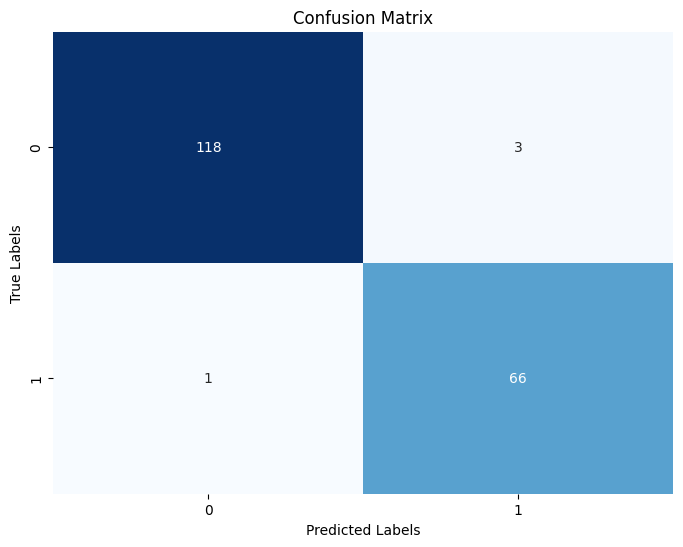

\begin{tabular}{lrrrr}
\toprule
{} &  Accuracy &  Precision &  Recall &  F1-Score \\
\midrule
0 &     0.979 &      0.979 &   0.985 &     0.971 \\
\bottomrule
\end{tabular}



In [ ]:
# Initialize the Decision tree classifier and fit
X_train, y_train = bcw_train.drop('target', axis=1), bcw_train['target']

svc_best = SVC(C=1, kernel='linear')
svc_best.fit(X_train.iloc[train], y_train.iloc[train])

X_test, y_test = bcw_test.drop('target', axis=1), bcw_test['target']
y_pred = svc_best.predict(X_test)

final_metrics = pd.DataFrame(data={'Accuracy': accuracy_score(y_test, y_pred),
                                   'Precision': accuracy_score(y_test, y_pred),
                                   'Recall': recall_score(y_test, y_pred),
                                   'F1-Score': f1_score(y_test, y_pred)}, index=[0])
final_metrics['Model'] = 'SVM'
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(final_metrics.iloc[:, :-1].to_latex(index=True,
                  float_format="{:.3f}".format,
))

In [ ]:
final_metrics = pd.DataFrame(data={'Accuracy': 0.979,
                                   'Precision': 0.979,
                                   'Recall': 0.985,
                                   'F1-Score': 0.971}, index=[0])
final_metrics['Model'] = 'SVM'
model_metrics = pd.concat([model_metrics, final_metrics], ignore_index=True)
model_metrics

,Accuracy,Precision,Recall,F1-Score,Model
0,0.882979,0.882979,0.820896,0.833333,GNB
1,0.936170,0.936170,0.880597,0.907692,KNN
2,0.904000,0.904000,0.881000,0.868000,DTREE
3,0.979000,0.979000,0.985000,0.971000,SVM


In [ ]:
model_metrics.to_csv(os.path.join('/content/drive/MyDrive/Datasets/SI_final_project', 'model_metrics.csv'), index=False)

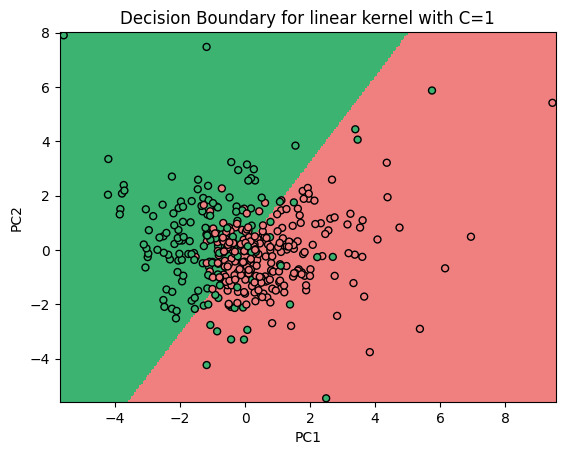

In [ ]:
# Calculamos la frontera de decisión.
svc_best = SVC(C=1, kernel='linear')
svc_best.fit(X_train.iloc[train], y_train.iloc[train])
xx, yy, zz = decision_boudary(svc_best, X_train.min(0)[pcs], X_train.max(0)[pcs], \
                                      X_train.shape[1], feature_ids=pcs)
# Pintamos la frontera de decisión
cmap = colors.ListedColormap(['lightcoral', 'mediumseagreen'])
plt.pcolormesh(xx, yy, zz.astype(float), cmap=cmap)
clrs = [ ('lightcoral', 'mediumseagreen')[int(y_i)] for y_i in y_train]
plt.scatter(X_train.values[:, pcs[0]], X_train.values[:, pcs[1]], ec='k', color=clrs, s=25)
plt.title(f'Decision Boundary for linear kernel with C=1')
plt.xlabel(f'PC{pcs[0]}')
plt.ylabel(f'PC{pcs[1]}')
plt.show()